# 使用StyleGAN2-FaceApp完成人像性别变换

GAN的出现使得深度学习领域有了更好的图像生成能力，StyleGAN则为受风格迁移Style transfer启发而设计了一种新的生成器网络结构，其生成的图像非常逼真，并且可以较为轻松的控制不同目标视觉特征，例如在虚拟人像生成中单独控制发色、发量、面部表情等生成表现。  

<center>
<figure>
<img src="https://ai-studio-static-online.cdn.bcebos.com/bed7c4c9b87a425b9de80c58a9a9d0a0521768ea9f724f43bf88678d21378fb7" style="height: 64px;"/>
</figure>
</center>

本期PaddleWeekly将为大家介绍一下来自[艾梦](https://github.com/HighCWu)大佬的人像编辑开源项目[Stylegan2-faceapp](https://github.com/HighCWu/stylegan2-faceapp)。在这个项目中，你可以轻松控制人物的性别、年龄、甚至是嘴巴大小等人像风格，  
<font color='red'> 如果只是想了解使用方式，可滚动页面至最底部的</font>**开始使用**<font color='red'>一节</font>。  

当然，若想了解其中的原理，甚至有意愿自己动手完成一个类似的项目，接下来就会简单讲解一下啦~


## 更详细的视频版讲解-欢迎一键三连

<iframe src="//player.bilibili.com/player.html?aid=378962432&bvid=BV1af4y1u7F6&cid=436041030&page=1" scrolling="no" border="0" frameborder="no" framespacing="0" allowfullscreen="true" style="width:512px;height:512px;"> </iframe>

## 原作者信息
原作者：[艾梦（HighCWu）](https://aistudio.baidu.com/aistudio/personalcenter/thirdview/50030)  
原作者项目：[【AI造梦堂】2 我们长得不一样，变大变小变漂亮](https://aistudio.baidu.com/aistudio/projectdetail/2377580)  
GitHub源码：[HighCWu/stylegan2-faceapp](https://github.com/HighCWu/stylegan2-faceapp)

<font color='red'>如果喜欢该项目，可以在GitHub上给出Star以此鼓励作者</font>。

原作者趣味小视频（同样欢迎一键三连）：
<center>
<iframe src="//player.bilibili.com/player.html?aid=421091634&bvid=BV183411C7sB&cid=423041466&page=1" scrolling="no" border="0" frameborder="no" framespacing="0" allowfullscreen="true" style="width:512px;height:512px;"> </iframe>
</center>

## Warmup

在学习StyleGAN人像编辑之前，以下几点能力可以先自测一下是否符合要求。  
当然，不符合也没有太大问题，毕竟还是有参考资料的嘛~  

<div align="center">
<img src=https://ai-studio-static-online.cdn.bcebos.com/4238aa3de1404dc3a501d6df5e6eac0c33c8b95cf9df4a949f40dd53d9695b6e width="200px">
</div>

### 前置能力
1. <font color='red'>Python基础能力</font>，至少有过简单的Python项目开发经验 <font color='red'>✓</font>  
2. <font color='red'> 具备飞桨PaddlePaddle</font> 或其他深度学习框架的使用能力 <font color='red'>✓</font>  
3. <font color='red'> 可自行搭建一个基础的DCGAN</font>，并完成形如MNIST数据集的生成任务<font color='red'>✓</font>     
4. 略读StyleGAN论文，字可以不看，但图一定得了解。【可选】  
5. 了解Pix2Pix形式的网络结构，例如U-Net、PSP、Deeplab 【可选】  
6. 了解SVD奇异值分解，可对简单的回归任务进行特征分解 【可选】  

### 相关资料
1. [DCGAN人像生成实战](https://aistudio.baidu.com/aistudio/projectdetail/1086168)
2. [StyleGAN2论文](https://arxiv.org/abs/1912.04958)
3. [U-Net实现](https://www.paddlepaddle.org.cn/documentation/docs/zh/develop/tutorial/cv_case/image_segmentation/image_segmentation.html)
4. [SVD应用案例](https://www.zhihu.com/question/31167170/answer/1791532442)

## 任务目标
输入一张待处理的人像+想要编辑的属性信息，输出一张编辑后的人像。  
这里我们提供了基于MNIST Demo和艾梦大佬的StyleGAN Demo，如在后者部分理解较为困难，可优先从基础的MNIST Demo进行入手实操。

### 初步建模
通过StyleGAN论文可知，在图中StyleGAN可以对一组向量（Z）进行分解，然后将分解后的风格向量（W）进行更加详细的拆分（W -> A1, A2, ...），最终经过多次上采样后生成出一张看似极其真实的人像数据。  

换句话来说，就是给出一组随机的向量，然后StyleGAN就能生成出一个随机的人像数据。

<div align="center">
<img src=https://ai-studio-static-online.cdn.bcebos.com/e83b048b09374da59efcd378587a9b3805910cdff32a44beb5a64d4ae31a0531 width="200px">
</div>

尽管StyleGAN可以生成一个非常真实的人像数据，但回归到我们的**任务目标**后有没有感觉这可能并不是我们想要的效果呢？

<div align="center">
<img src=https://ai-studio-static-online.cdn.bcebos.com/13c9ce5cb83948fd89043a4a971d010b9daacc1ec96b41fbb7f7f1947b27d1b4 width="200px">
</div>

在目标中，我们需要给出一张待处理的人像图片[N, C, H, W]，而StyleGAN只接收一组向量[N, D*]来标识要生成的信息[N, C, H, W]。显然人像图片和这组向量并没有直接转换的关系，那么就意味着只有StyleGAN的话，它并不能根据我们给出的图片来生成我们想要的编辑后人像效果，甚至可以说是给出一张图片它也未必能很轻松的生成出这张图片.

换句话来说，我们想要的是   

> [N, C, H, W] -> [N, C, H, W]  

但StyleGAN却是  

> [N, D*] -> [N, C, H, W]  

两者并不匹配

此外，在StyleGAN模型结构当中，虽然有提到将W风格向量分解为多个A子风格向量，但我们并不知道W和A是怎样的结构与格式，所以即使他们可以控制人像的性别、年龄等特征，由于这部分变成了“黑盒”，故我们也不能很直观的控制这部分的风格。

<div align="center">
<img src=https://ai-studio-static-online.cdn.bcebos.com/962893c90c1044f9afe005c4a787d412ae38c6004a184a5a844a74bdf192b66e width="200px">
</div>

那么艾梦大佬是如何建模的呢？  

在看艾佬源码之前，我们不妨试试这样想：

尽管我们不知道Z、W、以及A是如何生成的，但回想一下GAN任务解决了什么问题之后，似乎有了一点线索：没有Label的情况下GAN任务也能对这些未标注的数据进行学习。  

既然GAN可以对未标注的数据进行学习，那么其通过一组随机向量（Z）生成出一张图片，其实就相当于给这组随机向量指定了一个图片。  

我们既然可以拿到随机向量与生成图片的关系，那么我们能否借助该数据训练出一个“图片->Z向量"的模型呢？  

当然可以，<font color='red'>但由于篇幅有限，本期PaddleWeekly就仅介绍“图片->Z向量"的部分，关于风格编辑部分就放在下期啦~</font>  

那么我们就先拿MNIST数据集练练手吧~  

<div align="center">
<img src=https://ai-studio-static-online.cdn.bcebos.com/8d3d07ab9bdc48b1b1ae61ba6cc767de8835658e2a664f54b9ffafd64ebace74 width="200px">
</div>

### 任务分解

1. <font color='red'>完成一个基础的MNIST对抗网络模型，使其可以通过一组随机向量来生成一张随机的手写数字图像。  </font> 
可借助基础的DCGAN结构，训练出一组用于MNIST数据集的生成器、判别器模型。  
> 目的：掌握GAN的基础玩法。
2. <font color='red'>搭建出一个“图片->Z向量”的模型。</font>   
使其可以输入一张确定的图片，根据该图片来产出一个Z向量，用该Z向量传入根据1中完成的生成模型，使其可以生成出和刚刚输入的确定图片一样的风格。  
> 目的：得到出一个可自行控制的生成模型。
3. 输入一张图片，使其可以生成该图片相关风格的数据。
> 目的：尝试生成出自己喜欢的数字，为后续StyleGAN的人像编辑做准备。

### 任务一 搭建一个基础的抗网络模型

该部分使用MNIST数据集进行流程演示，如需查看很优秀的StyleGAN实现可参考[PaddleGAN](https://github.com/PaddlePaddle/PaddleGAN/blob/develop/ppgan/models/styleganv2_model.py)

这里需要注意的是，`from samplegan.reader import Reader`相关代码来源于本项目中的samplegan文件夹目录。

Cache file /home/aistudio/.cache/paddle/dataset/mnist/train-images-idx3-ubyte.gz not found, downloading https://dataset.bj.bcebos.com/mnist/train-images-idx3-ubyte.gz 
Begin to download

Download finished
Cache file /home/aistudio/.cache/paddle/dataset/mnist/train-labels-idx1-ubyte.gz not found, downloading https://dataset.bj.bcebos.com/mnist/train-labels-idx1-ubyte.gz 
Begin to download
........
Download finished
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/paddle/nn/layer/norm.py:641: UserWarning: When training, we now always track global mean and variance.
  "When training, we now always track global mean and variance.")


Acc: T [[[0.38550407]]] F [[[0.17145357]]]
Epoch_id: 0 Batch id: 0 	Loss: T  [0.51978725] F [1.9257443]


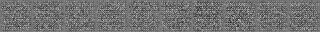

Acc: T [[[0.3182913]]] F [[[0.10905592]]]
Epoch_id: 0 Batch id: 400 	Loss: T  [0.4358863] F [2.3905215]


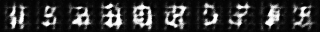

Acc: T [[[0.13953435]]] F [[[0.07865943]]]
Epoch_id: 1 Batch id: 0 	Loss: T  [0.158638] F [2.741798]


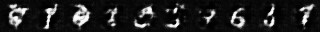

In [ ]:
# Author: Acer Zhang
# Datetime:2021/10/30 
# Copyright belongs to the author.
# Please indicate the source for reprinting.
import os
from IPython.display import display

import numpy as np
import paddle
from PIL import Image

from samplegan.reader import Reader
from samplegan.net import GenerateNet, DiscriminatorNet, weights_init

# 定义超参数
EPOCH = 10
BATCH_SIZE = 128

# 定义几个输出目录
OUT_PATH = "."
MODEL_PATH = os.path.join(OUT_PATH, "model")
RESULT_PATH = os.path.join(OUT_PATH, "generate")
os.makedirs(RESULT_PATH, exist_ok=True)

# 获取数据读取器
loader = paddle.io.DataLoader(Reader(noise=True), batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

# 新建一个生成网络和判别网络
g_net = GenerateNet()
d_net = DiscriminatorNet()

# 对两组网络做一次特殊的初始化（可以不做，效果可能会略差一点）
g_net.apply(weights_init)
d_net.apply(weights_init)

# 定义两组优化器，一组负责更新判别器，另一组负责更新生成器
opt_d = paddle.optimizer.Adam(parameters=d_net.parameters(), learning_rate=0.0002, beta1=0.5, beta2=0.999)
opt_g = paddle.optimizer.Adam(parameters=g_net.parameters(), learning_rate=0.0002, beta1=0.5, beta2=0.999)
bce = paddle.nn.BCELoss()

for epoch_id in range(EPOCH):
    for batch_id, (b_img, b_noise) in enumerate(loader()):
        # Batch ID, 真实的图像, 随机Z向量[N, 100, 1, 1, 1]
        opt_d.clear_grad()
        # 先使用判别器对 真实 的图像进行判断 [N, 1(图像颜色通道), 32(高度), 32(宽度)] -> [N, 1(Sigmoid后的“概率”值)]
        dis_true_result = d_net(b_img)
        # 计算判断的结果距离判断为“真”的损失
        loss_true = bce(dis_true_result, paddle.ones(shape=[BATCH_SIZE, 1, 1, 1], dtype="float32"))
        # 构建相关梯度
        loss_true.backward()

        # 使用生成网络对Z向量进行生成，[N, 100, 1, 1, 1] -> [N, 1(图像颜色通道), 32(高度), 32(宽度)]
        gen_img = g_net(b_noise)
        # 使用判别器对 生成 的图像进行判断 [N, 1(图像颜色通道), 32(高度), 32(宽度)] -> [N, 1(Sigmoid后的“概率”值)]
        dis_fake_result = d_net(gen_img.detach())
        # 计算判断的结果距离判断为“假”的损失
        loss_fake = bce(dis_fake_result, paddle.zeros(shape=[BATCH_SIZE, 1, 1, 1], dtype="float32"))
        # 构建相关梯度
        loss_fake.backward()
        # 更新判别器参数
        opt_d.step()
        opt_d.clear_grad()

        opt_g.clear_grad()
        # 使用生成网络对Z向量进行生成，[N, 100, 1, 1] -> [N, 1(图像颜色通道), 32(高度), 32(宽度)]
        gen_img = g_net(b_noise)
        # 使用判别器对 生成 的图像进行判断 [N, 1(图像颜色通道), 32(高度), 32(宽度)] -> [N, 1(Sigmoid后的“概率”值)]
        dis_fake_result = d_net(gen_img)
        # 为了让生成器生成的数据更加真实，那么我们就要计算生成器生成效果与为“真”的距离
        loss_fake = bce(dis_fake_result, paddle.ones(shape=[BATCH_SIZE, 1, 1, 1], dtype="float32"))
        # 构建相关梯度
        loss_fake.backward()
        # 更新判别器参数
        opt_g.step()
        opt_g.clear_grad()

        # 每几组数据展示一下效果
        if batch_id % 400 == 0:
            print("Acc: T",
                  (BATCH_SIZE - sum(dis_true_result.numpy())) / BATCH_SIZE,
                  "F", sum(dis_fake_result.numpy()) / BATCH_SIZE)
            print("Epoch_id:", epoch_id,
                  "Batch id:", batch_id,
                  "\tLoss: T ", loss_true.numpy(), "F", loss_fake.numpy())
            img_num = min((BATCH_SIZE, 10))
            gen_img = gen_img.numpy()
            display_img = gen_img[0][0]
            for img_id in range(1, img_num):
                display_img = np.concatenate([display_img, gen_img[img_id][0]], axis=-1)
            display_img = (display_img + 1) * 127
            im = Image.fromarray(display_img).convert("RGB")
            display(im)
    paddle.save(g_net.state_dict(), MODEL_PATH + f"/GEN_{epoch_id}")
    paddle.save(d_net.state_dict(), MODEL_PATH + f"/DIS_{epoch_id}")


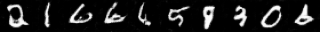

In [2]:
# 展示生成效果
display(im)

### 任务二 搭建出一个“图片->Z向量”的模型


import numpy as np
from paddle.io import DataLoader, Dataset

class RandomDataset(Dataset):
    def __getitem__(self, idx):
        data = np.random.random((2, 3)).astype('float32')

        return data

    def __len__(self):
        return 10

dataset = RandomDataset()
loader = DataLoader(dataset, batch_size=1)
data = next(loader())

In Paddle <= 2.0, data is in format '[Tensor(shape=(1, 2, 3), dtype=float32)]', and in Paddle >= 2.1, data is in format 'Tensor(shape=(1, 2, 3), dtype=float32)'



Epoch_id: 0 Batch id: 0 	Loss:  [0.17747608]


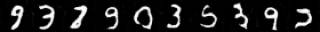

Epoch_id: 0 Batch id: 400 	Loss:  [0.01459002]


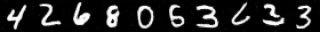

Epoch_id: 1 Batch id: 0 	Loss:  [0.01510367]


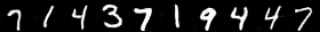

Epoch_id: 1 Batch id: 400 	Loss:  [0.01369584]


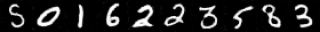

Epoch_id: 2 Batch id: 0 	Loss:  [0.01200246]


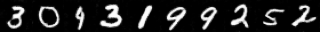

Epoch_id: 2 Batch id: 400 	Loss:  [0.01114345]


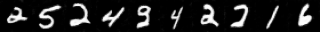

Epoch_id: 3 Batch id: 0 	Loss:  [0.01087063]


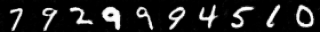

Epoch_id: 3 Batch id: 400 	Loss:  [0.0100005]


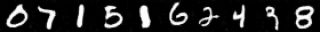

Epoch_id: 4 Batch id: 0 	Loss:  [0.00967336]


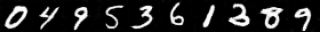

Epoch_id: 4 Batch id: 400 	Loss:  [0.01018554]


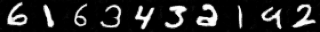

Epoch_id: 5 Batch id: 0 	Loss:  [0.00867267]


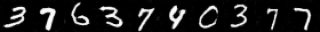

Epoch_id: 5 Batch id: 400 	Loss:  [0.00872002]


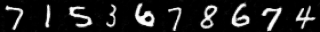

Epoch_id: 6 Batch id: 0 	Loss:  [0.00963834]


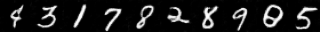

Epoch_id: 6 Batch id: 400 	Loss:  [0.00774657]


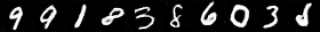

Epoch_id: 7 Batch id: 0 	Loss:  [0.008841]


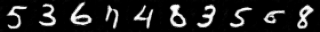

Epoch_id: 7 Batch id: 400 	Loss:  [0.0079348]


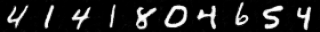

Epoch_id: 8 Batch id: 0 	Loss:  [0.00756115]


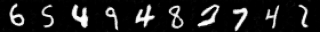

Epoch_id: 8 Batch id: 400 	Loss:  [0.0077491]


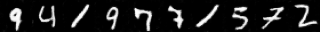

Epoch_id: 9 Batch id: 0 	Loss:  [0.00724086]


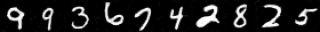

Epoch_id: 9 Batch id: 400 	Loss:  [0.00818059]


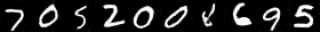

In [3]:
# Author: Acer Zhang
# Datetime:2021/10/30 
# Copyright belongs to the author.
# Please indicate the source for reprinting.

import os

import numpy as np
import paddle
from PIL import Image

from samplegan.reader import Reader
from samplegan.net import GenerateNet, MatchingNet, weights_init

EPOCH = 10
BATCH_SIZE = 128
OUT_PATH = "."
MODEL_PATH = os.path.join(OUT_PATH, "model")
RESULT_PATH = os.path.join(OUT_PATH, "generate")
os.makedirs(RESULT_PATH, exist_ok=True)

loader = paddle.io.DataLoader(Reader(noise=False), batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

g_net = GenerateNet()
m_net = MatchingNet()
m_net.apply(weights_init)

g_params = paddle.load(MODEL_PATH + "/GEN_9")

opt = paddle.optimizer.Adam(parameters=m_net.parameters(), learning_rate=0.0002)

sm1 = paddle.nn.SmoothL1Loss()

for epoch_id in range(EPOCH):
    for batch_id, b_img in enumerate(loader()):
        # 使用Z向量生成网络，输入真实图像然后生成Z [N, 1(图像颜色通道), 32(高度), 32(宽度)] -> [N, 100, 1, 1]
        b_noise = m_net(b_img)
        # 此处可以考虑冻结相关参数，赋值法简单但影响运行效率
        g_net.set_dict(g_params)
        # 使用生成的Z，传入生成网络 [N, 100, 1, 1] -> [N, 1(图像颜色通道), 32(高度), 32(宽度)]
        gen_img = g_net(b_noise)

        # 缩小到16x16而非32x32，16也算是做了个平滑，可考虑使用性能更好的lpips来计算相关损失
        loss_p2p = sm1(paddle.nn.functional.upsample(gen_img, size=[16, 16]),
                       paddle.nn.functional.upsample(b_img, size=[16, 16]))
        loss_p2p.backward()
        opt.step()
        opt.clear_grad()

        if batch_id % 400 == 0:
            print("Epoch_id:", epoch_id,
                  "Batch id:", batch_id,
                  "\tLoss: ", loss_p2p.numpy())
            img_num = min((BATCH_SIZE, 10))
            gen_img = gen_img.numpy()
            display_img = gen_img[0][0]
            for img_id in range(1, img_num):
                display_img = np.concatenate([display_img, gen_img[img_id][0]], axis=-1)
            display_img = (display_img + 1) * 127
            im = Image.fromarray(display_img).convert("RGB")
            display(im)

    paddle.save(m_net.state_dict(), MODEL_PATH + f"/M_{epoch_id}")


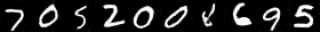

In [4]:
display(im)

### 任务三 基于任务一+任务二，生成出我们想要的数字

由于刚刚的DCGAN并不能指定生成我们想要的数字，这里我们基于任务一的图像生成模型，以及任务二的Z向量生成模型，组合一下使得我们可以做到：  
输入一张图片-> Z + 一丁点噪音 -> 生成一堆和输入相似的图片

/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/paddle/tensor/creation.py:125: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if data.dtype == np.object:


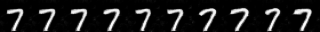

看，这些数字7是不一样的，我们可以在基础的7上生成相似数字的图片


In [5]:
# Author: Acer Zhang
# Datetime:2021/10/31 
# Copyright belongs to the author.
# Please indicate the source for reprinting.

import os

import numpy as np
import paddle

from PIL import Image

from samplegan.reader import ts
from samplegan.net import GenerateNet, MatchingNet

INPUT_IMAGE_PATH = "samplegan/7.jpg"
OUT_PATH = "."
MODEL_PATH = os.path.join(OUT_PATH, "model")
RESULT_PATH = os.path.join(OUT_PATH, "generate")
MAT_EPOCH = 9
GEN_EPOCH = 9

# 实例化图片生成网络和Z向量生成网络，并加载权重
g_net = GenerateNet()
m_net = MatchingNet()

m_params = paddle.load(MODEL_PATH + f"/M_{MAT_EPOCH}")
g_params = paddle.load(MODEL_PATH + f"/GEN_{GEN_EPOCH}")

g_net.set_dict(g_params)
m_net.set_dict(m_params)

# 打开一张数字7的图片
ori_img = Image.open(INPUT_IMAGE_PATH).convert("L")
ori_img = np.array(ori_img)
ori_img = ts(ori_img)
ori_img = paddle.to_tensor([ori_img.astype("float32")])

def gen(step=0):
    # 使用Z生成网络，基于数字7生成出一个Z向量，并且加入少许随机噪声，方便生成出不一样的图片
    z = m_net(ori_img) + paddle.randn([100, 1, 1], dtype="float32") * 0.02 * step
    # 生成图片
    gen_img = g_net(z).numpy()
    return gen_img[0][0]

# 绘制图片
display_img = gen()
for img_id in range(1, 10):
    display_img = np.concatenate([display_img, gen(img_id)], axis=-1)
display_img = (display_img + 1) * 127
im = Image.fromarray(display_img).convert("RGB")
display(im)
print("看，这些数字7是不一样的，我们可以在基础的7上生成相似数字的图片")

## 下面是基于StyleGAN2-FaceAPP的性别编辑代码实现👇
GitHub源码：[HighCWu/stylegan2-faceapp](https://github.com/HighCWu/stylegan2-faceapp) 欢迎为作者Star~

# 开始体验


使用流程：  
<font color='red'> 1. 在左侧文件夹中上传一张你想要处理的图像。  
2. 右键该文件，重命名为input.png。  
3. 点击下方每个方块左上角的运行按钮，依次运行下方4块代码。  
</font> 

In [ ]:
# 安装此次试验需要的依赖
!pip install dlib-19.22.0-cp37-cp37m-linux_x86_64.whl
!pip install -r requirements.txt -i https://pypi.douban.com/simple

### 步骤1 检测面部，并进行剪裁

100%|██████████| 97358/97358 [00:01<00:00, 64888.07it/s]


Number of faces detected: 1
Detection 0: Left: 115 Top: 64 Right: 270 Bottom: 219
Part 0: (138, 127), Part 1: (139, 144) ...


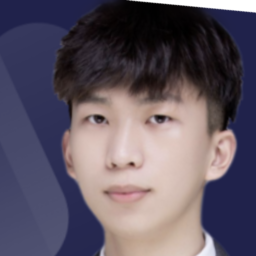

In [1]:
import numpy as np

from PIL import Image, ImageOps
from IPython.display import display
from crop import align_face

# 裁剪，照片的路径可替换为自己上传的图片的路径
# 使用的算法是先用dlib检测面部，再旋转人脸到正常角度
img1, mask1 = align_face('ssc.png')


img1_display = np.concatenate([np.asarray(img1), np.asarray(mask1)[...,None]], -1) 
display(Image.fromarray(img1_display).resize((256,256), Image.BILINEAR))

### 步骤2 通过PSP获取Latent code（Z）

100%|██████████| 1757764/1757764 [00:26<00:00, 67097.96it/s]
W1128 18:59:43.264956  3448 device_context.cc:404] Please NOTE: device: 0, GPU Compute Capability: 7.0, Driver API Version: 11.0, Runtime API Version: 10.1
W1128 18:59:43.268692  3448 device_context.cc:422] device: 0, cuDNN Version: 7.6.


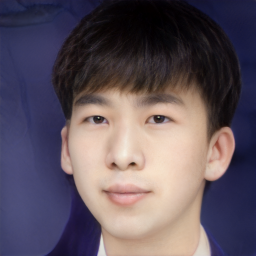

In [2]:
from editor import edit
from utils import save_video

import paddle
import numpy as np

from PIL import Image
from IPython.display import display
from utils import get_pSp
from paddle.vision import transforms
from projector import make_image

# 创建编码模型，用于获取照片的大致向量表示
pSp = get_pSp(
    model_type='ffhq-inversion',
    size=1024,
    style_dim=512,
    n_mlp=8,
    channel_multiplier=2
)

transform = transforms.Compose(
    [
        transforms.Resize(256),
        transforms.CenterCrop(256),
        transforms.Transpose(),
        transforms.Normalize([127.5, 127.5, 127.5], [127.5, 127.5, 127.5]),
    ]
)

img1_tensor = paddle.to_tensor(transform(img1)).unsqueeze(0)

with paddle.no_grad():
    # Z出来啦
    img1_recon, latent_code1 = pSp(img1_tensor, randomize_noise=False, return_latents=True)
    img1_recon = make_image(img1_recon)[0]
paddle.save({'latent_code': latent_code1[0]}, 'example3-pSp.pd')
Image.fromarray(img1_recon).save('example3-pSp.png')
display(Image.fromarray(img1_recon).resize((256,256), Image.BILINEAR))


### 步骤3 根据刚刚Latent code生成随机编辑的人像

这里更偏向性别的变换

100%|██████████| 101/101 [00:07<00:00, 12.90it/s]


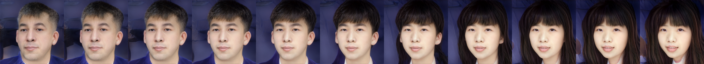

t:   7%|▋         | 11/150 [00:00<00:01, 104.23it/s, now=None]

Moviepy - Building video example3-factorized-1.mp4.
Moviepy - Writing video example3-factorized-1.mp4



Moviepy - Done !
Moviepy - video ready example3-factorized-1.mp4
制作完毕，生成结果可见 example3-factorized-1.mp4'


In [3]:
# 使用分解器可以算出多个属性控制偏移向量
# 选择不同的向量进行测试，可以大致推断其对应编辑的属性
# 当属性偏移程度为0时，即原图
# 注：要获取分解器算出的向量需要耗费一些时间

style_index = 1 # 分解器中向量的索引，取1时比较接近于性别变换

imgs_seq, latents_seq = edit(
    latent_code1, # # 经过pSp得到的照片的向量表示
    pSp.decoder, # 传入生成器
    start_offset=-5, # 属性偏移程度的初始值
    final_offset=5, # 属性偏移程度的最终值
    offset_step_size=0.1, # 从初始偏移值到最终偏移值，每隔一个大小为0.1的步长生成一次图像
    use_factorizer=True, # 使用分解器的向量作为属性控制偏移向量，获取分解的向量需要耗费一些时间
    factorizer_style_index=1 # 选择分解器中向量的索引（一共512个，所以范围是从0到511）
)

img_seq1 = imgs_seq[0]
latent_seq1 = latents_seq[0]
img_styles = []
for i, img in enumerate(img_seq1):
    if i % 10 == 0: # 每隔10步抽取一张图像用作展示
        img_styles.append(img)
img_style1 = np.concatenate(img_styles, 1)
Image.fromarray(img_style1).save(f'example3-factorized-{style_index}.png')
display(Image.fromarray(img_style1).resize((64*len(img_styles),64), Image.BILINEAR))

# 变化过程保存为视频
fps = 30
duration = 5
save_video(
    img_seq1,
    f'example3-factorized-{style_index}.mp4',
    fps, duration
)
print(f"制作完毕，生成结果可见 example3-factorized-{style_index}.mp4'")

> 本文部分表情包来源：P站 甘城なつき